# Designing Tapered Cost

In [1]:
import torch
import imp
import ppuu.costs
import ppuu.costs.policy_costs_km

imp.reload(ppuu.costs.policy_costs_km)

PolicyCostKMTaper = ppuu.costs.policy_costs_km.PolicyCostKMTaper

from ppuu.data.dataloader import DataStore, Dataset, Normalizer, UnitConverter
from ppuu import configs

store = DataStore('/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/')
ds = Dataset(store, 'train', 20, 30, 40, shift=False, random_actions=False)
loader = torch.utils.data.DataLoader(ds, batch_size=2)
normalizer = Normalizer(store.stats)

ImportError: cannot import name 'UnitConverter' from 'ppuu.data.dataloader' (/home/us441/work/pytorch-PPUU-sync/ppuu/data/dataloader.py)

In [2]:
UnitConverter.pixels_to_m(20)

3.0833333333333335

In [3]:
config = PolicyCostKMTaper.Config()
config.masks_power_x = 30
config.masks_power_y = 30
cost = PolicyCostKMTaper(config, None, normalizer)

config2 = PolicyCostKMTaper.Config()
config2.masks_power_x = 4
config2.masks_power_y = 4 
cost2 = PolicyCostKMTaper(config2, None, normalizer)

In [4]:
it = iter(loader)

In [5]:
batch = next(it)
batch = next(it)
#batch = next(it)
#batch = next(it)
#batch = next(it)
#batch = next(it)

In [6]:
batch['car_sizes']

tensor([[ 5.9000, 14.9000],
        [ 5.9000, 14.9000]])

In [7]:
meta = {}

mask, mask_lo = cost2.get_masks(batch['target_images'], batch['target_states'], batch['actions'], batch['car_sizes'], True, metadata=meta)
print(mask.sum(dim=(-1, -2)))

mask2, mask_lo2 = cost2.get_masks(batch['target_images'], batch['target_states'], batch['actions'], batch['car_sizes'], True, metadata=meta)
print(mask2.sum(dim=(-1, -2)))

tensor([[173.5995, 174.2408, 174.5760, 174.6036, 174.3259, 173.7462, 172.9490,
         172.1311, 171.5270, 171.2039, 171.0627, 170.8845, 170.4734, 169.7945,
         168.8698, 167.6956, 166.5657, 165.5475, 164.6783, 163.9570, 163.3314,
         162.8196, 162.3937, 162.0255, 161.6467, 161.2624, 160.9255, 160.6677,
         160.5122, 160.4634],
        [137.4036, 137.3813, 137.3766, 137.3832, 137.4083, 137.4566, 137.5208,
         137.5812, 137.6296, 137.6653, 137.6957, 137.7295, 137.7627, 137.7908,
         137.8072, 137.8147, 137.8156, 137.8137, 137.8137, 137.8137, 137.8137,
         137.8091, 137.8055, 137.8164, 137.8471, 137.8870, 137.9123, 137.9215,
         137.9003, 137.8594]])
tensor([[173.5995, 174.2408, 174.5760, 174.6036, 174.3259, 173.7462, 172.9490,
         172.1311, 171.5270, 171.2039, 171.0627, 170.8845, 170.4734, 169.7945,
         168.8698, 167.6956, 166.5657, 165.5475, 164.6783, 163.9570, 163.3314,
         162.8196, 162.3937, 162.0255, 161.6467, 161.2624, 160.9255, 1

In [8]:
mask.shape

torch.Size([2, 30, 117, 24])

In [9]:
meta.keys()

dict_keys(['width_y', 'y_d', 'r_y_prime_b', 'r_y_prime_b_width', 'x_major', 'r_y_prime', 'r_y_prime_clamped'])

In [10]:
from matplotlib import pyplot as plt

# plt.imshow(meta['y_multiply_coefficient'][0][0])
# plt.colorbar()
# plt.plot(meta['y_multiply_coefficient'][0][0][:, 10])

In [11]:
from ppuu.data.dataloader import UnitConverter


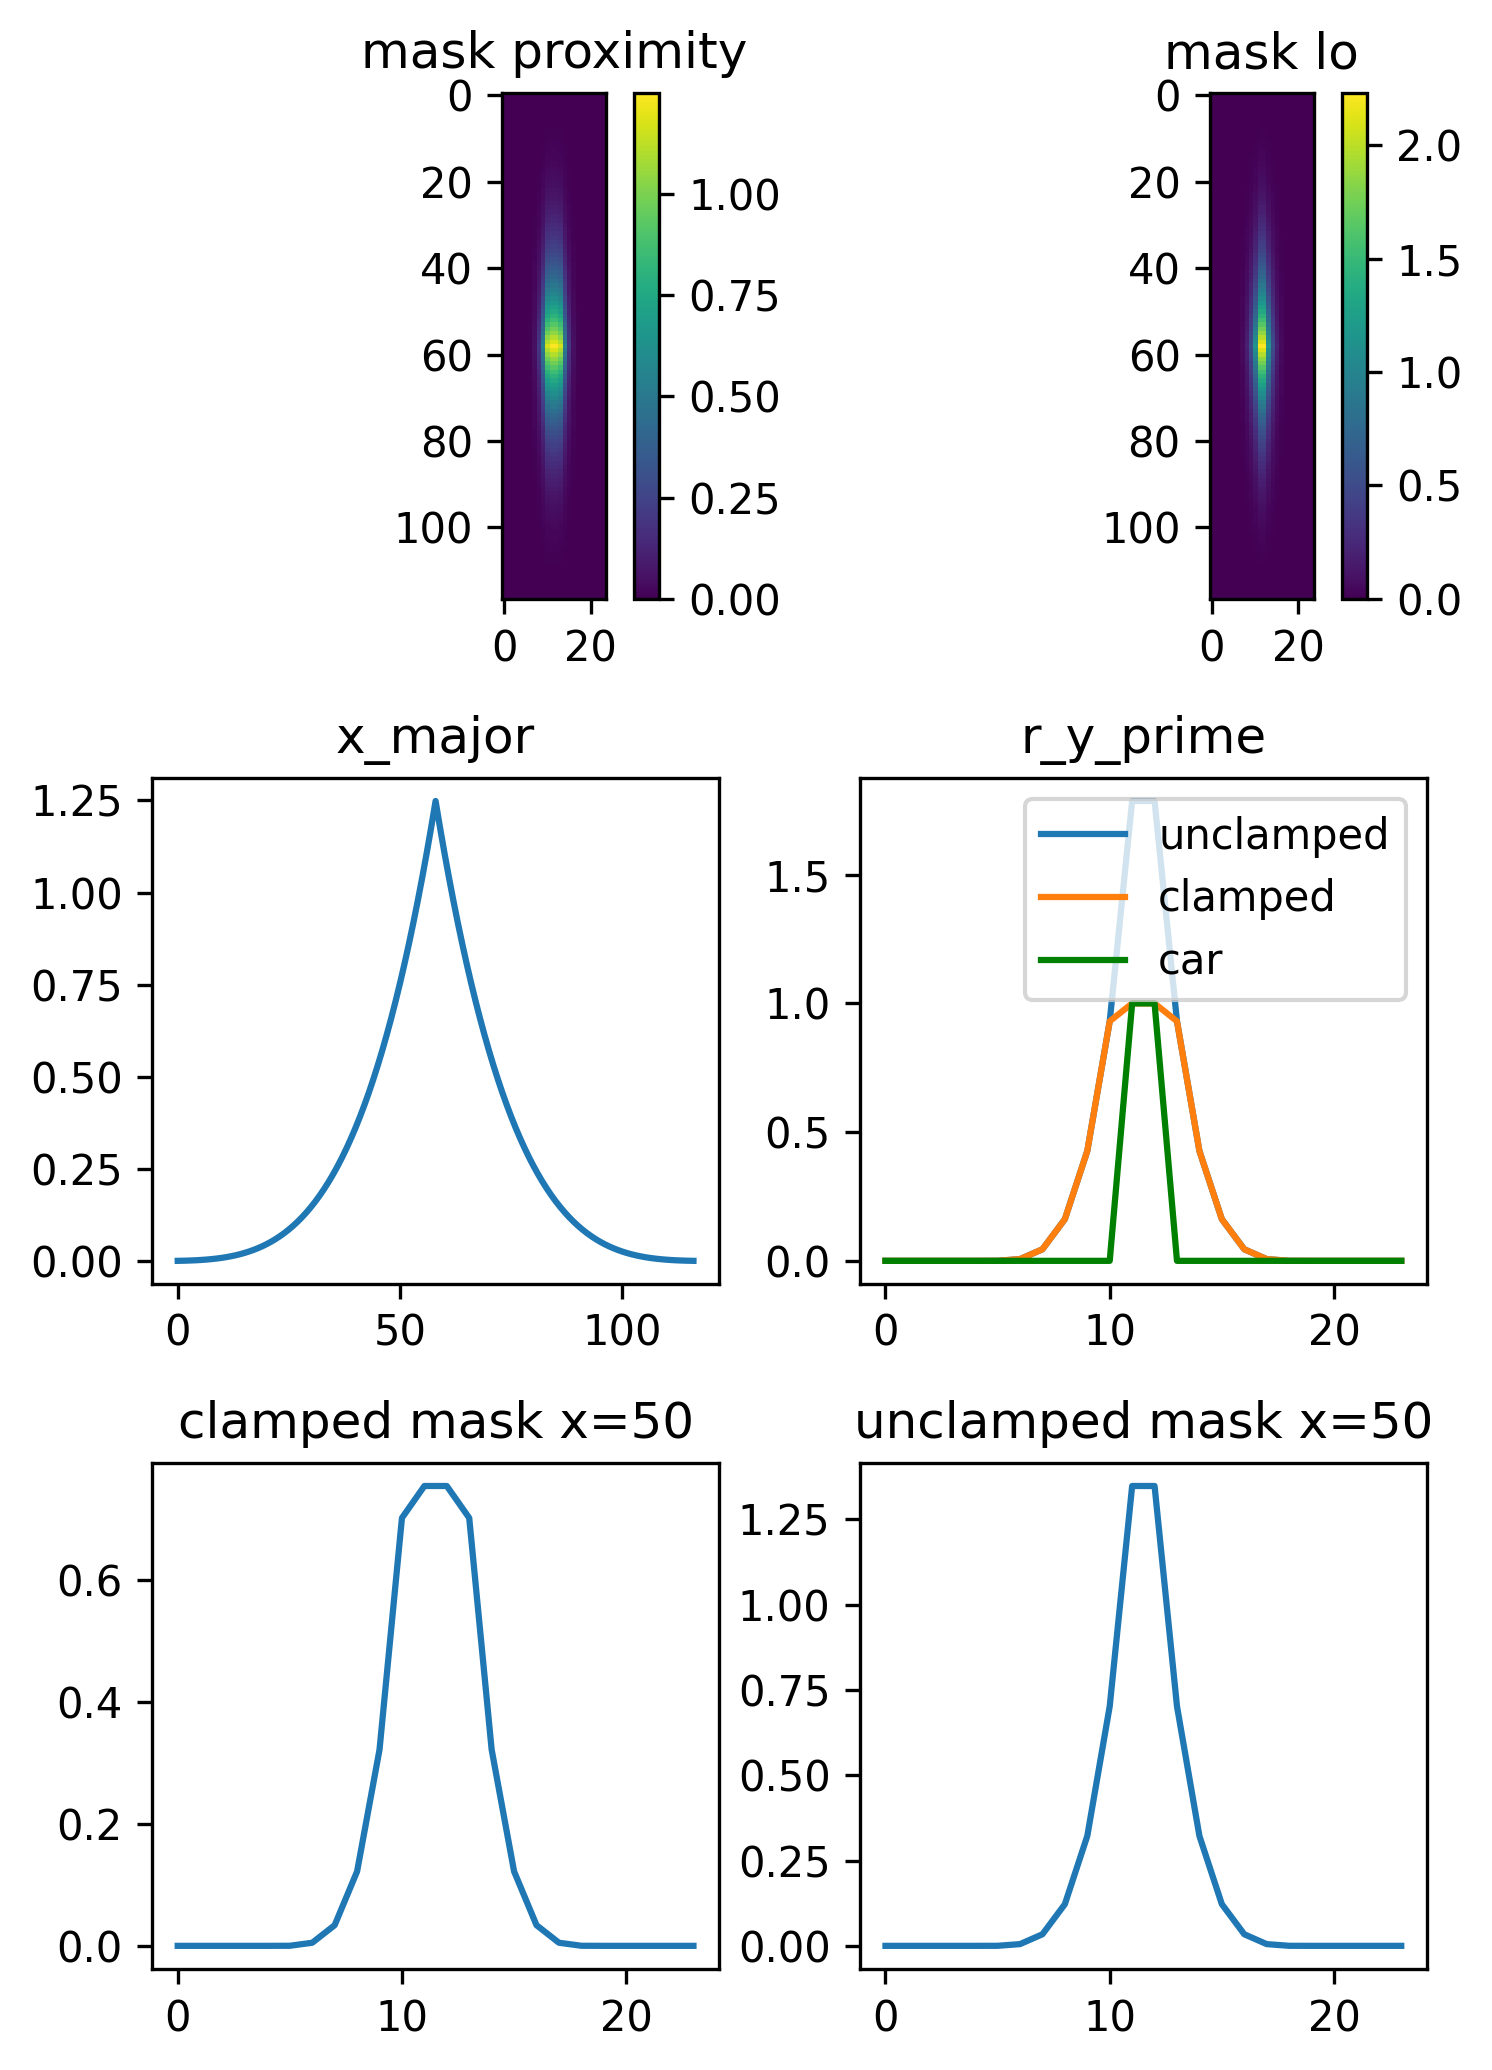

In [12]:
from matplotlib import pyplot as plt

def plot_sub(a, index, label=None):
    plt.plot(a[index], label=index)
    
%matplotlib inline

plt.figure(dpi=300, figsize=(5, 7))

plt.subplot(321)
plt.imshow(mask[0][0])
plt.colorbar()
plt.title('mask proximity')

plt.subplot(322)
plt.imshow(mask_lo[0][0])
plt.title('mask lo')
plt.colorbar()

plt.subplot(323)
plt.plot(meta['x_major'][0][0][:, 11])
plt.title('x_major')

plt.subplot(324)
plt.plot(meta['r_y_prime'][0][0][50], label='unclamped')
plt.plot(meta['r_y_prime_clamped'][0][0][50], label='clamped')
plt.plot(meta['width_y'][0][0][50], c='g', label='car')
plt.title('r_y_prime')
plt.legend()

plt.subplot(325)
plt.title('clamped mask x=50')
plt.plot(mask[0][0][50])

plt.subplot(326)
plt.title('unclamped mask x=50')
plt.plot(mask_lo[0][0][50])

plt.tight_layout()

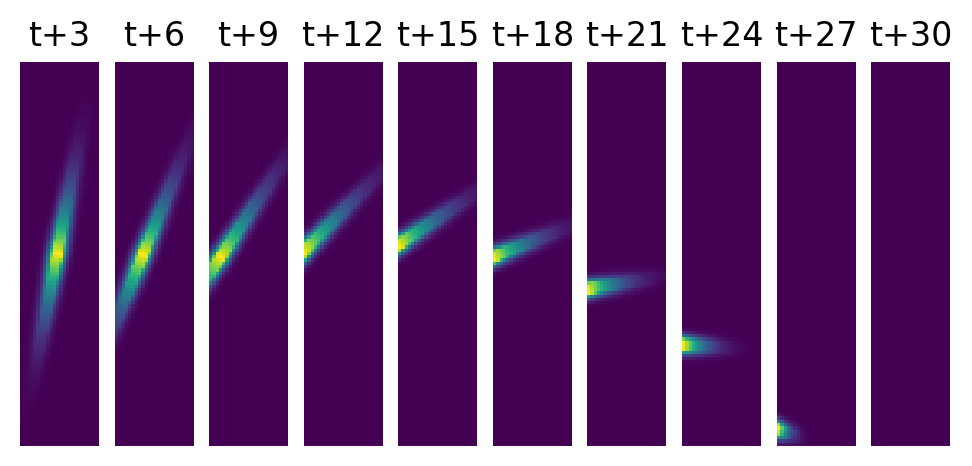

In [18]:
from ppuu.modeling.km import predict_states_seq

test_actions = batch['actions'].clone()
test_actions[..., -2] = 2
test_actions[..., -1] = 2

pred_states = predict_states_seq(batch['input_states'][:, -1], test_actions, normalizer=cost.normalizer)

mask, mask_lo = cost2.get_masks(torch.zeros_like(batch['target_images']), pred_states, batch['actions'], batch['car_sizes'], True, metadata=meta, ref_states=batch['target_states'])

plt.figure(dpi=200)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title(f't+{(i + 1)*3}')
    plt.imshow(mask[0, i*3 + 2].detach().cpu())
    plt.axis('off')

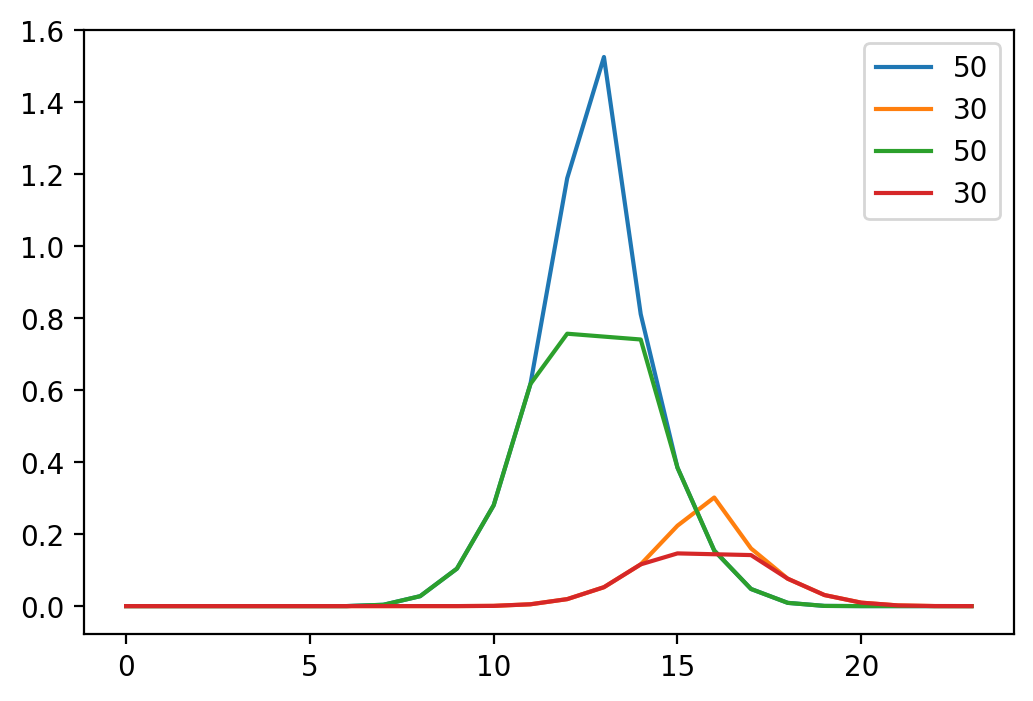

In [14]:
m = mask[0][0]
plt.figure(dpi=200)
    
plot_sub(mask_lo[0][0], 50)
plot_sub(mask_lo[0][0], 30)

plot_sub(mask[0][0], 50)
plot_sub(mask[0][0], 30)
plt.legend()

Text(0.5, 1.0, 'lateral component')

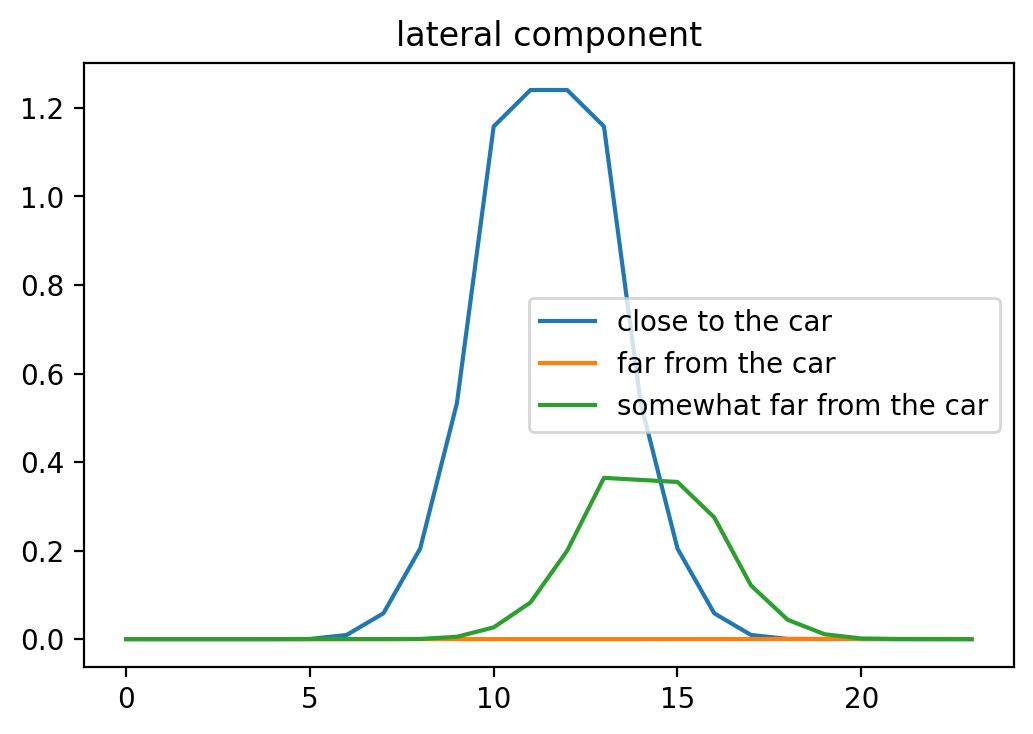

In [15]:
plt.figure(dpi=200)
plt.plot(mask[0][0][58], label='close to the car')
plt.plot(mask[0][0][0], label='far from the car')
plt.plot(mask[0][0][40], label='somewhat far from the car')
plt.legend()
plt.title('lateral component')

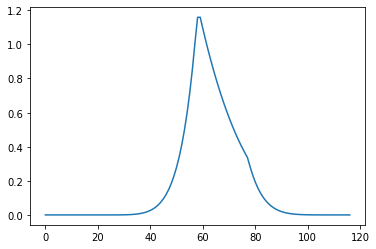

In [16]:
plt.plot(m.T[10])

In [17]:
plt.plot(xx[0][0][0])
xx[1][0][0]

NameError: name 'xx' is not defined

In [ ]:
plt.imshow(multipliers[0][0])

In [ ]:
%matplotlib inline 
import numpy as np

def z_function(x, y):
#     x = np.sqrt(np.abs(x))
#     y = np.sqrt(np.abs(y))
    return  1 - np.sqrt(x * x + y * y)

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, Z, cmap='winter')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

# Putting fake data

In [ ]:
def plot_images(images):
    images = images.detach().cpu().numpy()
    step = max(images.shape[1] // 10, 1)
    l = images.shape[1] // step
    f, axs = plt.subplots(1, l, dpi=200)
    for i in range(max(l, 1)):
        image = np.transpose(images[0][i * step], (1, 2, 0))
        if l == 1:
            axs.imshow(image)
            axs.set_axis_off()
        else:
            axs[i].imshow(image)
            axs[i].set_axis_off()
            
cnd_car_in_front = torch.zeros_like(batch['input_images'])
target_car_in_front = torch.zeros_like(batch['target_images'])

# car_slice = slice(13, 20) # to the right
# car_slice = slice(4, 11) # to the left
car_slice = slice(0, 24)
# car_slice_x = slice(70, 85) # behind
car_slice_x = slice(40, 55) # in front
# car_slice_x = slice(0, 117) # everywhere
cnd_car_in_front[:, :, 1, car_slice_x, car_slice] = 1
target_car_in_front[:, :, 1, car_slice_x, car_slice] = 1
plot_images(cnd_car_in_front)

In [ ]:
cnd_car_in_front.shape

In [ ]:
target_car_in_front.shape

In [ ]:
actions = torch.zeros(*target_car_in_front.shape[:2], 2)
actions.requires_grad = True

In [ ]:
actions.shape

In [ ]:
print(batch['input_states'].shape)

In [ ]:
from ppuu.modeling.km import predict_states_seq

ref_images = target_car_in_front
ref_states = predict_states_seq(batch['input_states'][:, -1], actions, normalizer)

pred_states = predict_states_seq(batch['input_states'][:, -1], actions, normalizer)

inputs = {
    "input_images": batch['input_images'],
    "input_states": batch['input_states'],
    "car_sizes": batch['car_sizes'],
    "ref_states": ref_states,
    "ref_images": ref_images,
}
predictions = {
    "pred_states": pred_states,
    "pred_images": ref_images,
    "pred_actions": actions,
}

cost2.config.u_reg = 0.0
cost2.traj_landscape = False

# costs = self.cost.compute_state_costs_for_training(inputs, pred_images, pred_states, actions, car_size)
costs = cost2.calculate_cost(inputs, predictions)

In [ ]:
costs['policy_loss'].sum().backward()

In [27]:
actions.grad

tensor([[[ 3.1316e-02, -5.2926e-07],
         [ 2.9125e-02, -5.0674e-07],
         [ 2.7022e-02, -4.8377e-07],
         [ 2.5004e-02, -4.6041e-07],
         [ 2.3071e-02, -4.3675e-07],
         [ 2.1222e-02, -4.1285e-07],
         [ 1.9456e-02, -3.8881e-07],
         [ 1.7773e-02, -3.6470e-07],
         [ 1.6171e-02, -3.4061e-07],
         [ 1.4650e-02, -3.1661e-07],
         [ 1.3209e-02, -2.9280e-07],
         [ 1.1847e-02, -2.6927e-07],
         [ 1.0564e-02, -2.4609e-07],
         [ 9.3575e-03, -2.2337e-07],
         [ 8.2282e-03, -2.0119e-07],
         [ 7.1750e-03, -1.7964e-07],
         [ 6.1971e-03, -1.5883e-07],
         [ 5.2936e-03, -1.3885e-07],
         [ 4.4639e-03, -1.1979e-07],
         [ 3.7073e-03, -1.0175e-07],
         [ 3.0229e-03, -8.4833e-08],
         [ 2.4101e-03, -6.9140e-08],
         [ 1.8682e-03, -5.4770e-08],
         [ 1.3964e-03, -4.1827e-08],
         [ 9.9405e-04, -3.0414e-08],
         [ 6.6047e-04, -2.0637e-08],
         [ 3.9495e-04, -1.2599e-08],
 

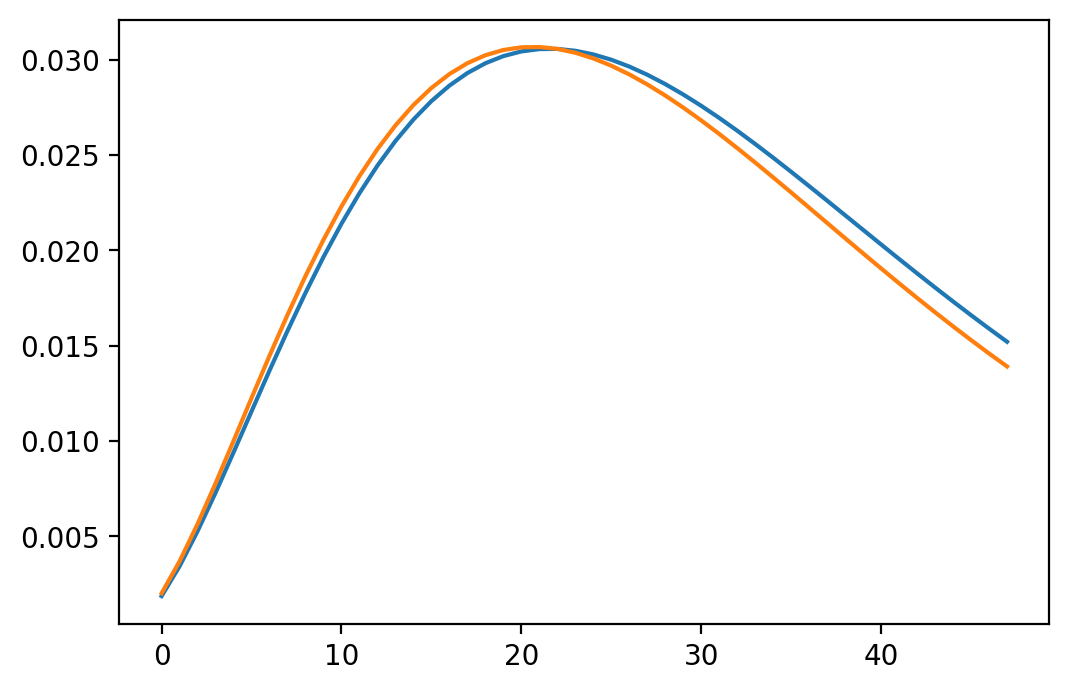

In [28]:
def get_mean_gradient(actions_value, powers):
    config = PolicyCostKMTaper.Config()
    config.masks_power_x = powers
    config.masks_power_y = powers
    cost = PolicyCostKMTaper(config, None, normalizer)
    
    actions = torch.zeros(*target_car_in_front.shape[:2], 2)
    actions[:, :, 0] = actions_value
    actions.requires_grad = True
    
    ref_images = target_car_in_front
    ref_states = predict_states_seq(batch['input_states'][:, -1], actions, normalizer)

    pred_states = predict_states_seq(batch['input_states'][:, -1], actions, normalizer)

    inputs = {
        "input_images": batch['input_images'],
        "input_states": batch['input_states'],
        "car_sizes": batch['car_sizes'],
        "ref_states": ref_states,
        "ref_images": ref_images,
    }
    predictions = {
        "pred_states": pred_states,
        "pred_images": ref_images,
        "pred_actions": actions,
    }

    cost.config.u_reg = 0.0
    cost.traj_landscape = False

    # costs = self.cost.compute_state_costs_for_training(inputs, pred_images, pred_states, actions, car_size)
    costs = cost.calculate_cost(inputs, predictions)
    
    costs['policy_loss'].sum().backward()
    
    return actions.grad.mean(dim=(1, 2))

res = []
for p in range(2, 50):
    res.append(get_mean_gradient(0, p))

res = torch.stack(res)

plt.figure(dpi=200)
plt.plot(res[:, 0])
plt.plot(res[:, 1])

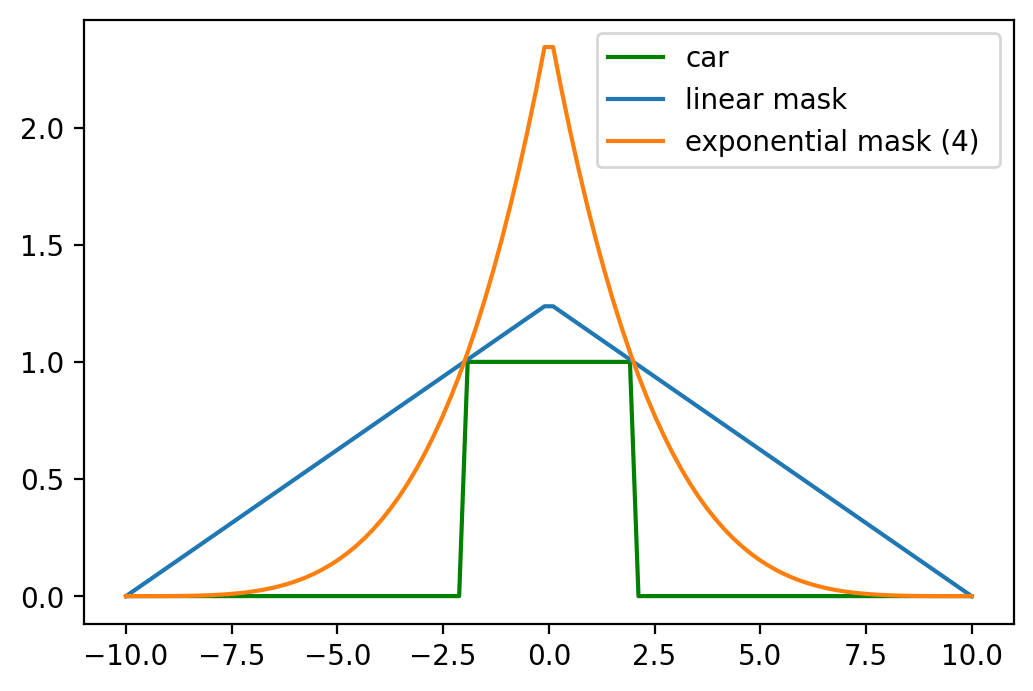

In [29]:
import numpy as np

plt.figure(dpi=200)

N = 100
WIDTH = 4

y = np.zeros(N)

x = np.linspace(-10, 10, N)

k = np.fabs(x) < (WIDTH / 2)

y[k] = 1
plt.plot(x, y, label='car', c='g')

SD = 4
LOC_0 = SD + WIDTH / 2 
LOC_1 = WIDTH / - 2

f = -1 / (LOC_0 - LOC_1) * (np.fabs(x) + LOC_1) + 1

plt.plot(x, f, label='linear mask')

plt.plot(x, f ** 4, label='exponential mask (4) ')

plt.legend()